In [1]:
###Problem Statement

In [2]:
#To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.
#The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.
#The data set contains the following diseases:

#Actinic keratosis
#Basal cell carcinoma
#Dermatofibroma
#Melanoma
#Nevus
#Pigmented benign keratosis
#Seborrheic keratosis
#Squamous cell carcinoma
#Vascular lesion




In [7]:
#Importing all the important libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, cv2
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")

In [8]:
#Data Reading/Data Understanding → Defining the path for train and test images 

In [14]:
# Importing Skin Cancer Data
# Defining the path for train and test images
data_dir_train = pathlib.Path("Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [15]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


In [16]:
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

118


In [17]:
# Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [22]:
#Dataset Creation→ Create train & validation dataset from the train directory with a batch size of 32. Also, make sure you resize your images to 180*180.

In [18]:
# Loading the training data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [19]:
# Loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [20]:
# Loading the testing data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb')

Found 118 files belonging to 9 classes.


In [21]:
# Listing out all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [23]:
#Dataset visualisation → Create a code to visualize one instance of all the nine classes present in the dataset

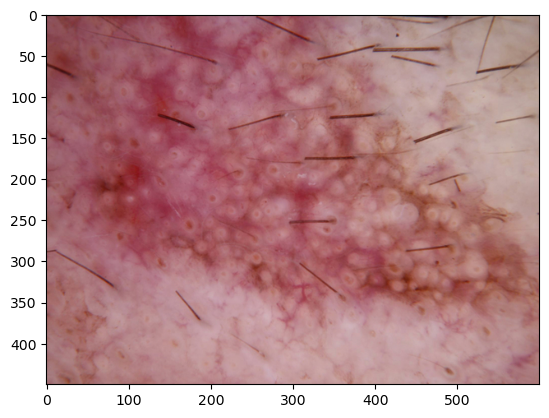

In [24]:
image = plt.imread((list(data_dir_train.glob(class_names[0]+'/*.jpg'))[0]))
plt.imshow(image)

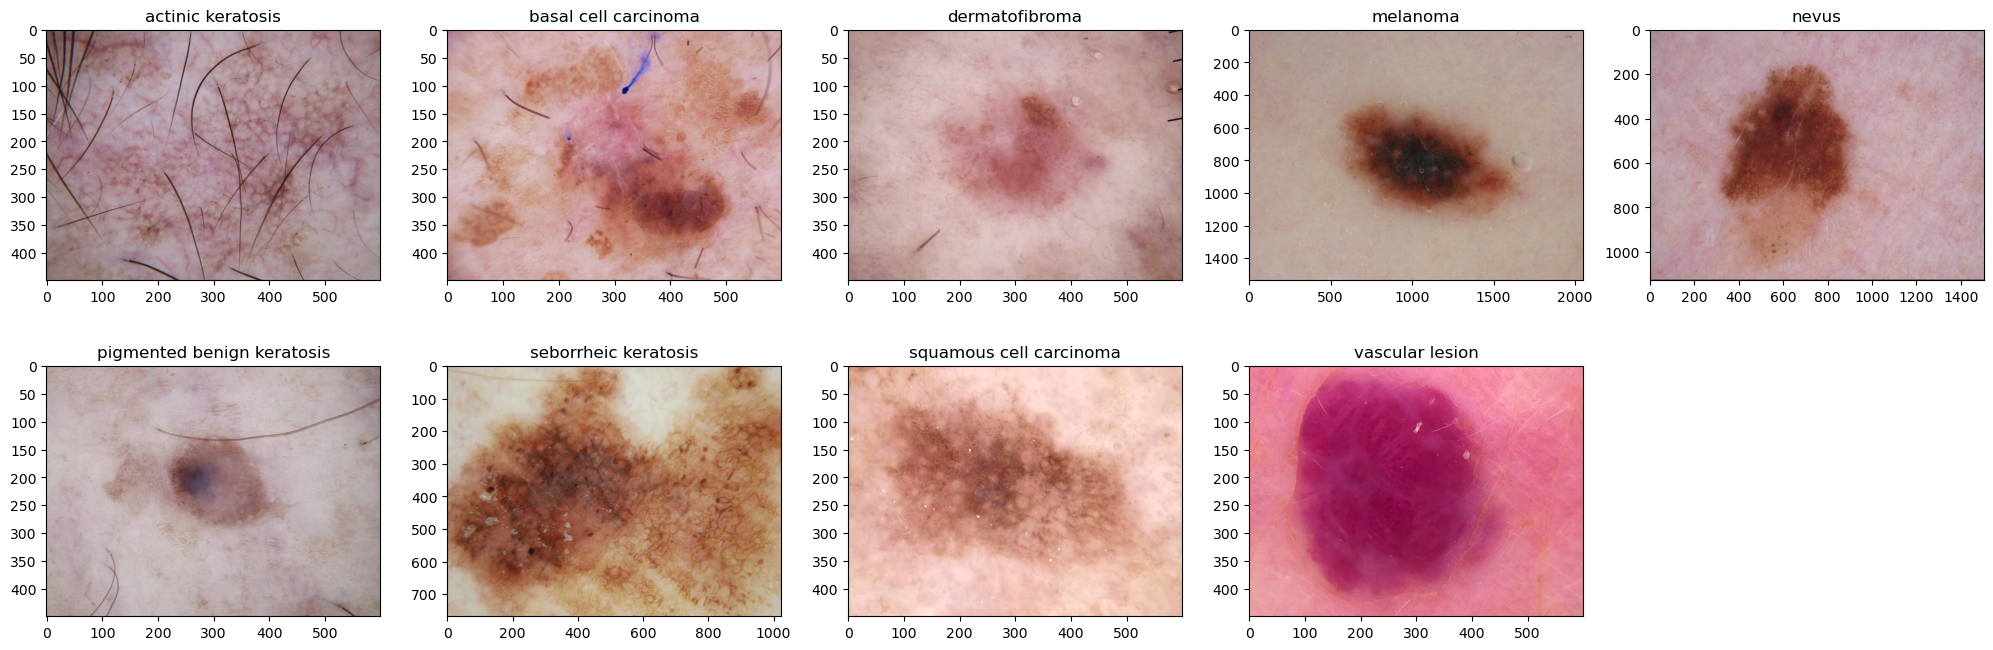

In [25]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(25,8))
for i in range(len(class_names)):
  plt.subplot(2,5,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [27]:
# Configure the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.\
# `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [28]:
# Method to create plots of the loss and accuracy on the training and validation sets:
def plot_cnn_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [29]:
#Model Building & training : 
#Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescale images to normalize pixel values between (0,1).
#Choose an appropriate optimiser and loss function for model training
#Train the model for ~20 epochs
#Write your findings after the model fit. You must check if there is any evidence of model overfit or underfit.

In [30]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [31]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 259200)            0

In [32]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 157s 3s/step - loss: 2.6109 - accuracy: 0.2879 - val_loss: 1.6195 - val_accuracy: 0.4273
Epoch 2/20
56/56 [==============================] - 144s 3s/step - loss: 1.4897 - accuracy: 0.4821 - val_loss: 1.4905 - val_accuracy: 0.4564
Epoch 3/20
56/56 [==============================] - 143s 3s/step - loss: 1.3306 - accuracy: 0.5324 - val_loss: 1.4244 - val_accuracy: 0.5235
Epoch 4/20
56/56 [==============================] - 147s 3s/step - loss: 1.2250 - accuracy: 0.5608 - val_loss: 1.3581 - val_accuracy: 0.5436
Epoch 5/20
56/56 [==============================] - 155s 3s/step - loss: 1.1140 - accuracy: 0.6088 - val_loss: 1.5400 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 148s 3s/step - loss: 1.0494 - accuracy: 0.6228 - val_loss: 1.5458 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 157s 3s/step - loss: 0.8898 - accuracy: 0.6758 - val_loss: 1.6032 - val_accuracy: 0.5391
Epoch 8/20
56

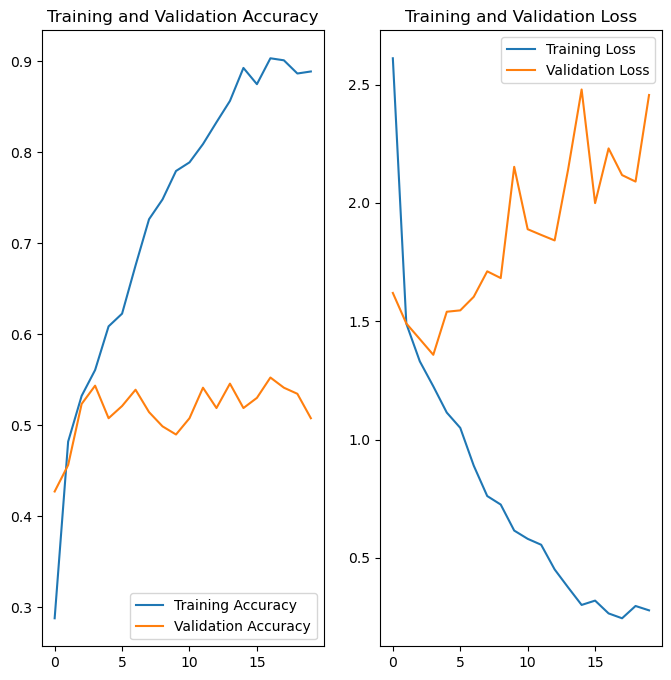

In [33]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

In [34]:
#Chose an appropriate data augmentation strategy to resolve underfitting/overfitting 

In [35]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

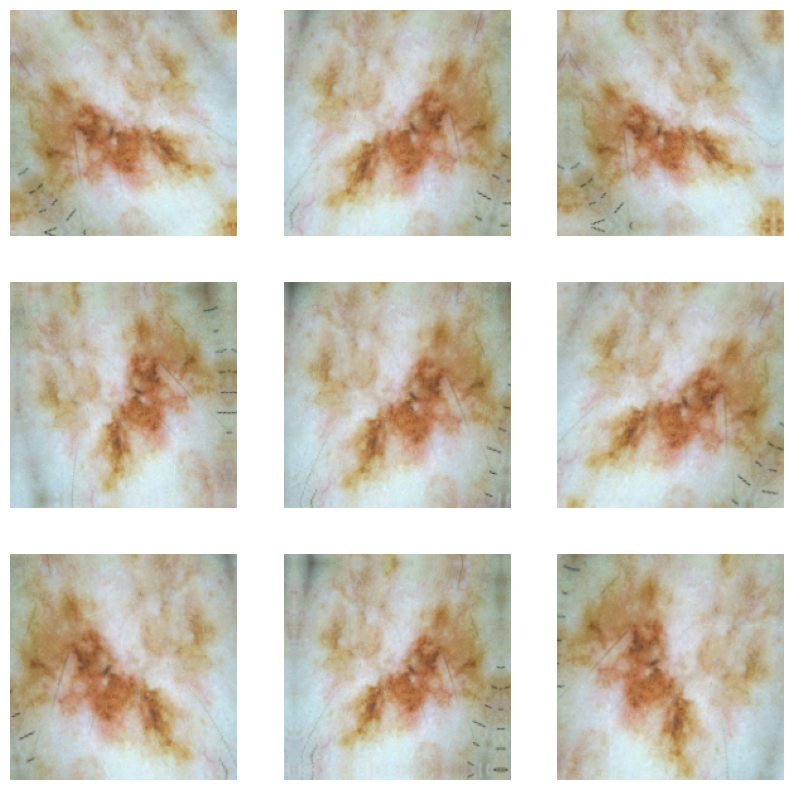

In [36]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [37]:
#Model Building & training on the augmented data :
#Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model rescale images to normalize pixel values between (0,1).
#Choose an appropriate optimiser and loss function for model training
#Train the model for ~20 epochs
#Write your findings after the model fit, see if the earlier issue is resolved or not?

In [38]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [39]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                 

In [40]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 147s 3s/step - loss: 3.2026 - accuracy: 0.2121 - val_loss: 1.9995 - val_accuracy: 0.2662
Epoch 2/20
56/56 [==============================] - 143s 3s/step - loss: 1.8548 - accuracy: 0.3292 - val_loss: 1.7482 - val_accuracy: 0.3781
Epoch 3/20
56/56 [==============================] - 146s 3s/step - loss: 1.6186 - accuracy: 0.4157 - val_loss: 1.4924 - val_accuracy: 0.5257
Epoch 4/20
56/56 [==============================] - 148s 3s/step - loss: 1.4803 - accuracy: 0.4799 - val_loss: 1.4914 - val_accuracy: 0.4653
Epoch 5/20
56/56 [==============================] - 146s 3s/step - loss: 1.4196 - accuracy: 0.4849 - val_loss: 1.5360 - val_accuracy: 0.4586
Epoch 6/20
56/56 [==============================] - 148s 3s/step - loss: 1.3543 - accuracy: 0.5257 - val_loss: 1.4724 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 147s 3s/step - loss: 1.3442 - accuracy: 0.5151 - val_loss: 1.3811 - val_accuracy: 0.5347
Epoch 8/20
56

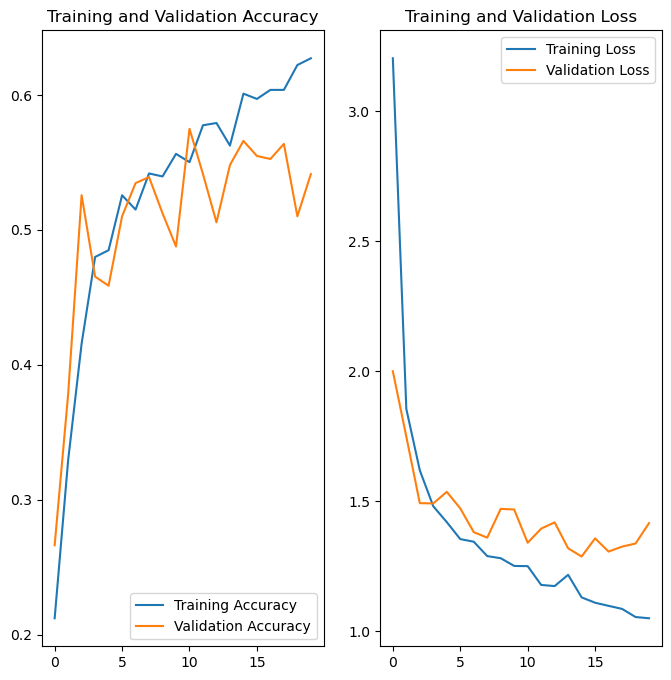

In [41]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

In [42]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [43]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                 

In [44]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 143s 3s/step - loss: 2.7726 - accuracy: 0.2310 - val_loss: 1.7900 - val_accuracy: 0.3579
Epoch 2/20
56/56 [==============================] - 146s 3s/step - loss: 1.8234 - accuracy: 0.3499 - val_loss: 1.6442 - val_accuracy: 0.3937
Epoch 3/20
56/56 [==============================] - 143s 3s/step - loss: 1.6130 - accuracy: 0.4397 - val_loss: 1.5228 - val_accuracy: 0.4631
Epoch 4/20
56/56 [==============================] - 148s 3s/step - loss: 1.4756 - accuracy: 0.4916 - val_loss: 1.4525 - val_accuracy: 0.5034
Epoch 5/20
56/56 [==============================] - 154s 3s/step - loss: 1.4856 - accuracy: 0.4782 - val_loss: 1.4740 - val_accuracy: 0.4631
Epoch 6/20
56/56 [==============================] - 154s 3s/step - loss: 1.4261 - accuracy: 0.5123 - val_loss: 1.4599 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 150s 3s/step - loss: 1.3501 - accuracy: 0.5195 - val_loss: 1.4422 - val_accuracy: 0.4586
Epoch 8/20
56

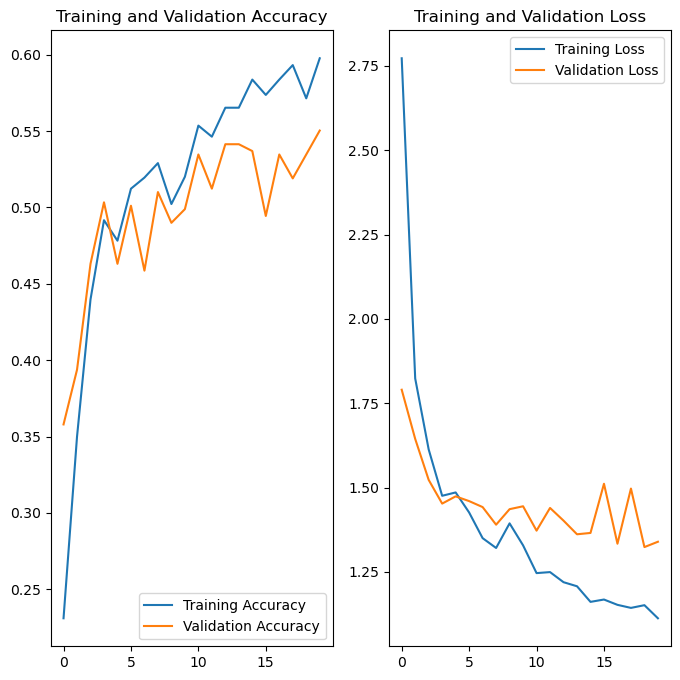

In [45]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

In [47]:
#Class distribution: Examine the current class distribution in the training dataset 
#- Which class has the least number of samples?
#- Which classes dominate the data in terms of the proportionate number of samples?

In [48]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


In [49]:
#Handling class imbalances: Rectify class imbalances present in the training dataset with Augmentor library.

In [50]:
!pip install Augmentor

In [54]:
path_to_training_dataset="E:/ML and AI/Deep Learning/Melanoma Detection Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i,output_directory="E:/ML and AI/Deep Learning/Melanoma Detection Assignment/CNN_assignment/"+i+"/")
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to E:/ML and AI/Deep Learning/Melanoma Detection Assignment/CNN_assignment/actinic keratosis/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1413F533CD0>: 100%|██████████| 500/500 [00:08<00:00, 59.26 Samples/s]


Initialised with 376 image(s) found.
Output directory set to E:/ML and AI/Deep Learning/Melanoma Detection Assignment/CNN_assignment/basal cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x141426D4D30>: 100%|██████████| 500/500 [00:04<00:00, 104.41 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to E:/ML and AI/Deep Learning/Melanoma Detection Assignment/CNN_assignment/dermatofibroma/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1413F593F10>: 100%|██████████| 500/500 [00:05<00:00, 93.10 Samples/s] 


Initialised with 438 image(s) found.
Output directory set to E:/ML and AI/Deep Learning/Melanoma Detection Assignment/CNN_assignment/melanoma/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x14142FB4370>: 100%|██████████| 500/500 [00:40<00:00, 12.24 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to E:/ML and AI/Deep Learning/Melanoma Detection Assignment/CNN_assignment/nevus/.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x14142FAAB50>: 100%|██████████| 500/500 [00:35<00:00, 14.13 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to E:/ML and AI/Deep Learning/Melanoma Detection Assignment/CNN_assignment/pigmented benign keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x14142F12B80>: 100%|██████████| 500/500 [00:08<00:00, 58.68 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to E:/ML and AI/Deep Learning/Melanoma Detection Assignment/CNN_assignment/seborrheic keratosis/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x14100F3E7C0>: 100%|██████████| 500/500 [00:18<00:00, 27.34 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to E:/ML and AI/Deep Learning/Melanoma Detection Assignment/CNN_assignment/squamous cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x14100DCFD90>: 100%|██████████| 500/500 [00:07<00:00, 63.94 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to E:/ML and AI/Deep Learning/Melanoma Detection Assignment/CNN_assignment/vascular lesion/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x14100F3E880>: 100%|██████████| 500/500 [00:08<00:00, 58.06 Samples/s]                  


In [55]:
data_dir_train = pathlib.Path("E:/ML and AI/Deep Learning/Melanoma Detection Assignment/CNN_assignment/")
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

4500


In [56]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [57]:
dict_new = dict(zip(path_list, lesion_list_new))
df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])

In [58]:
df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

In [59]:
# initializing the parameter to load the images
batch_size = 32
img_height = 180
img_width = 180

In [60]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6857 files belonging to 10 classes.
Using 5486 files for training.


In [61]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6857 files belonging to 10 classes.
Using 1371 files for validation.


In [62]:
#Model Building & training on the rectified class imbalance data :
#Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescale images to normalize pixel values between (0,1).
#Choose an appropriate optimiser and loss function for model training
#Train the model for ~30 epochs
#Write your findings after the model fit, see if the issues are resolved or not?

In [63]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [64]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                 